<a href="https://colab.research.google.com/github/akaliutau/tensorflow-grimoire/blob/main/notebooks/interpretability_of_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Interpretability of CNN

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

### Visualizing intermediate activations

In [2]:
model = ResNet50V2(
    include_top=True,  # Include the classification layer at the top
    weights="imagenet",  # Load pre-trained weights from ImageNet
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,  # 1000 classes for ImageNet
    classifier_activation="softmax",
)

In [3]:
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://github.com/akaliutau/tensorflow-grimoire/blob/main/pictures/orange-cat.jpg?raw=true")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

sample_tensor = get_img_array(img_path, target_size=(224, 224))

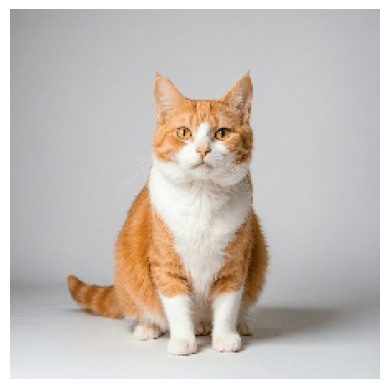

In [4]:
plt.axis("off")
plt.imshow(sample_tensor[0].astype("uint8"))
plt.show()

In [5]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        #print(layer.name)
        if layer.name.endswith("block1_1_conv") or layer.name.startswith("max_pooling"):
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

**Using the model to compute layer activations**

In [6]:
activations = activation_model.predict(sample_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 56, 56, 64)


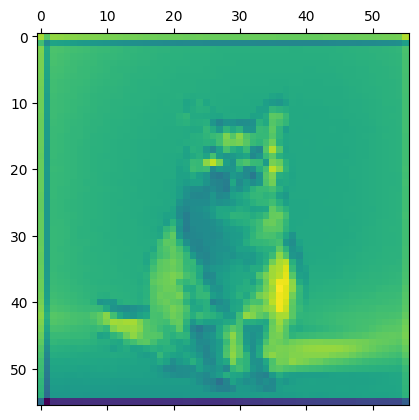

In [8]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

**Visualizing every channel in every intermediate activation**

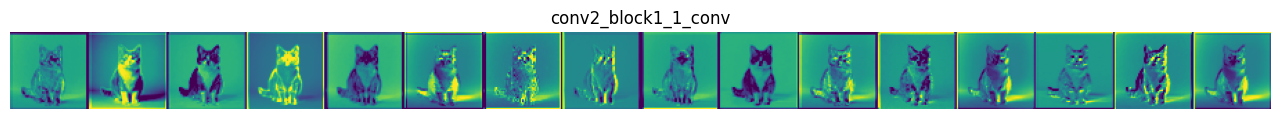

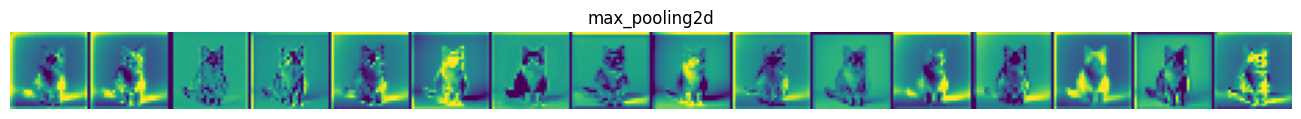

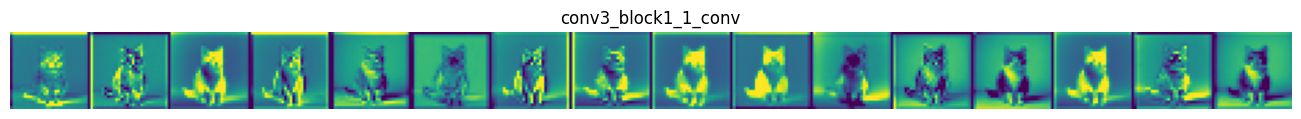

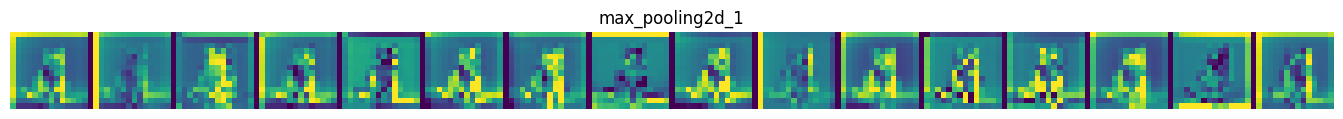

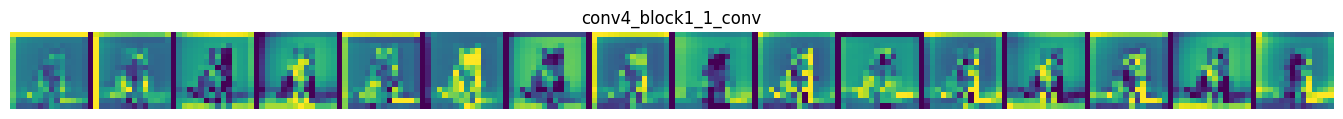

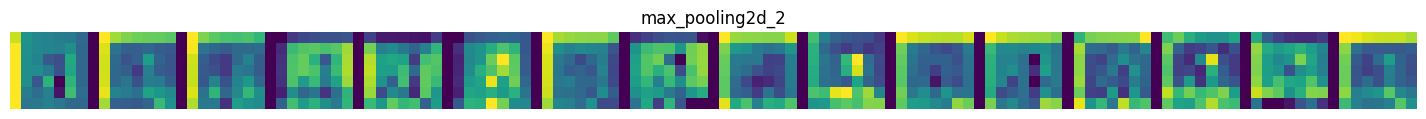

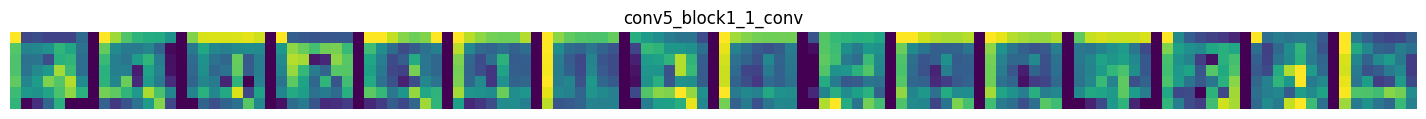

In [9]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = min(16, layer_activation.shape[-1])
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Extracting specific layers

In [10]:
# Original Model
input_tensor = keras.layers.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, (3, 3), activation="relu", name="conv_1")(input_tensor)
x = keras.layers.MaxPooling2D((2, 2), name="pool_1")(x)
x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="conv_2")(x)
x = keras.layers.MaxPooling2D((2, 2), name="pool_2")(x)
x = keras.layers.Flatten(name="flatten")(x)
x = keras.layers.Dense(10, activation="softmax", name="output")(x)
model = keras.Model(inputs=input_tensor, outputs=x)

# Layer selection
layer_name = "conv_2"

# New model
layer_output_tensor = model.get_layer(name=layer_name).output
new_model = keras.Model(inputs=model.input, outputs=layer_output_tensor)

# compare model structure
print("Original Model Summary:")
model.summary()
print("\nNew Model Summary:")
new_model.summary()


Original Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │          16,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)


New Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 11, 11, 64)          │          18,496 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,816 (73.50 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

### Visualizing CNN filters
On the example of Xception. We do not download the last (classification) layer

In [11]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=True)

In [12]:
sample_tensor = get_img_array(img_path, target_size=(299, 299))

Accessing all layers in model (this also can be done via `model.summary()`)
Note the types of layers

In [13]:
for layer in model.layers:
    print(f"{layer.name}, dtype={type(layer)}")


input_layer_2, dtype=<class 'keras.src.layers.core.input_layer.InputLayer'>
block1_conv1, dtype=<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
block1_conv1_bn, dtype=<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
block1_conv1_act, dtype=<class 'keras.src.layers.activations.activation.Activation'>
block1_conv2, dtype=<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
block1_conv2_bn, dtype=<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
block1_conv2_act, dtype=<class 'keras.src.layers.activations.activation.Activation'>
block2_sepconv1, dtype=<class 'keras.src.layers.convolutional.separable_conv2d.SeparableConv2D'>
block2_sepconv1_bn, dtype=<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
block2_sepconv2_act, dtype=<class 'keras.src.layers.activations.activation.Activation'>
block2_sepconv2, dtype=<class 'keras.src.layers.convolutional.separable_conv2d.SeparableConv2D'>
block2_sep

**Creating a feature extractor model**

In [14]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name) # retrieve the actual layer object within the trained model that corresponds to the block3_sepconv1
# build a new model from input till block3_sepconv1 as the last layer
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [15]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(sample_tensor)
)

In [16]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

**Loss maximization via stochastic gradient ascent**

In [17]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [18]:
img_width = 299
img_height = 299

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [19]:
def convert2filter(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

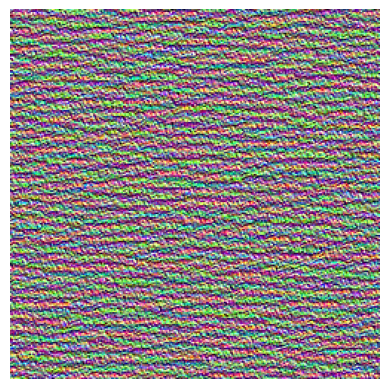

In [20]:
plt.axis("off")
plt.imshow(convert2filter(generate_filter_pattern(filter_index=2)))

**Generating a grid of all filter response patterns in a layer**

In [21]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = convert2filter(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_mosaic_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

**Setting up a model that returns the last convolutional output**

In [22]:
last_conv_layer_name = "block14_sepconv2_act"
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**Reapplying the classifier on top of the last convolutional output**

In [23]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**Retrieving the gradients of the top predicted class**

First, we compute the gradient of the predicted output with respect to the activation of a specific convolutional layer in a neural network.

1) initiate a tf.GradientTape to record all operations performed on variables that are being watched, allowing us to compute gradients later.

2) compute the last covn layer (1, 10, 10, 2048) - a batch of size = 1 (single image in this case), 10x10 with 2048 channels (feature maps) in the convolutional layer's output.

3) tell the tape to watch last_conv_layer_output and it will track how changes in this tensor influence subsequent calculations.

4) compute the gradients of the predicted class probability (top_class_channel) with respect to the activations of the watched convolutional layer (last_conv_layer_output).
This gradient tells us how much each spatial location in the convolutional layer's output contributed to the model's prediction for the chosen class.



In [40]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(sample_tensor)
    print(last_conv_layer_output.shape)
    tape.watch(last_conv_layer_output)
    # feed the input and get the prediction
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    print(preds.shape) # vector of prob distribution
    print(top_class_channel.shape) # the actual value of max probability

grads = tape.gradient(top_class_channel, last_conv_layer_output)
print(grads.shape)

(1, 10, 10, 2048)
(1, 1000)
(1,)
(1, 10, 10, 2048)


**Gradient pooling and channel-importance weighting**

In [41]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
print(pooled_grads.shape)
last_conv_layer_output = last_conv_layer_output.numpy()[0]
print(last_conv_layer_output.shape)
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)
print(heatmap)

(2048,)
(10, 10, 2048)
[[ 0.00000000e+00  8.01988964e-09  1.10465930e-08  1.11815552e-07
   2.35036254e-07  3.05119755e-07  2.73960325e-07  7.87512064e-08
   0.00000000e+00  0.00000000e+00]
 [ 5.22157961e-09  6.11659132e-08  1.18825554e-07  7.21676543e-07
   1.28553984e-06  1.20802804e-06  9.07175945e-07  5.64806669e-07
   1.02181170e-08  0.00000000e+00]
 [ 1.37029730e-08  8.06921534e-08  1.31134016e-06  5.87880004e-06
   7.88444504e-06  7.74126420e-06  6.68697066e-06  4.29905276e-06
   4.78749882e-07  1.77066148e-08]
 [-2.51515075e-09  1.88181687e-07  3.06344737e-06  8.70386611e-06
   1.15630137e-05  1.07701053e-05  9.48493471e-06  5.56305758e-06
   1.11736040e-06  9.01547708e-08]
 [-9.63790825e-10  1.49540512e-07  3.34068136e-06  8.46478360e-06
   1.15702533e-05  1.14757786e-05  1.02448594e-05  5.59798809e-06
   1.70667761e-06  2.12889518e-07]
 [-2.07436273e-08  1.49587819e-07  2.36203141e-06  5.49556808e-06
   7.95295819e-06  7.63417484e-06  6.65678454e-06  2.91719789e-06
   1.11979

**Heatmap post-processing**

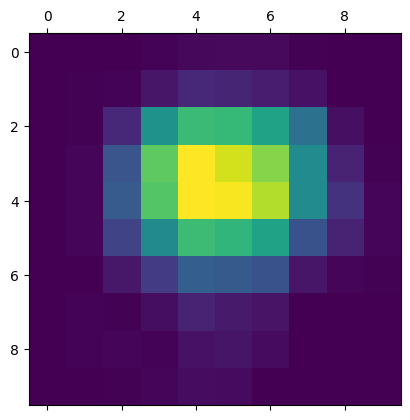

In [26]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Superimposing the heatmap on the original picture**

<ipython-input-35-d7c9368a6fe8>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


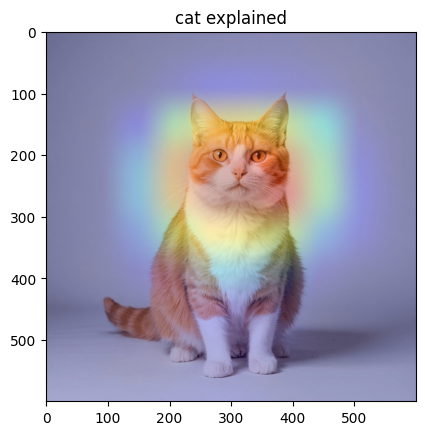

In [35]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

explained_img = jet_heatmap * 0.4 + img
explained_img = keras.utils.array_to_img(explained_img)
plt.title("cat explained")
plt.imshow(explained_img)

#save_path = "cat_explained.jpg"
#explained_img.save(save_path)